# Project: Investigate US Gun Registration Data

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

The report will investigate the gun registration data in the US recorded by the FBI over the period of 1998 to 2017. The data will ba analysed in parallel with the US state-level census data, although most variables in the latter only have a maximum of two data points per state.

The gun data comes from the FBI's NICS (National Instant Criminal Background Check System). The NICS is leveraged to determine whether a prospective buyer is eligible to buy firearms or explosives. Gun shops call into this system to ensure that each customer does not have a criminal record or isn’t otherwise ineligible to make a purchase. 

To gain insights from the datasets, we will ask the following questions and we will clean and analyse our data to try to answer them in the end of the report:
1. Which states have been most profilic in gun numbers over the years?
2. What census data are most associated with high gun per capita?
3. What features are most associated with the highest profile state in guns?

First of all, let's import the necessary data analysis modules:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
import folium
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy import stats
import statsmodels.stats.api as sms
import ssl
from urllib.request import urlopen
import json
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
%matplotlib inline

<a id='wrangling'></a>
## Data Wrangling

In this section, we will clean and prepare the data for analysis later.

### General Properties


First, load in data from the spreadsheets.

In [2]:
df_css = pd.read_csv('U.S. Census Data.csv', skipfooter=20, engine='python')
df_gun = pd.read_excel('gun_data.xlsx')

Let's see if the endnotes have been removed completely from the tail of the census data.

In [3]:
df_css.tail()

,Fact,Fact Note,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
60,"Veteran-owned firms, 2012",NaN,"41,943","7,953","46,780","25,915","252,377","51,722","31,056","7,206",...,8604,59379,"213,590","18,754","8,237","76,434","49,331","12,912","39,830","6,470"
61,"Nonveteran-owned firms, 2012",NaN,"316,984","56,091","427,582","192,988","3,176,341","469,524","281,182","60,318",...,66219,469392,"2,057,218","219,807","63,317","548,439","461,401","94,960","370,755","51,353"
62,"Population per square mile, 2010",NaN,94.4,1.2,56.3,56,239.1,48.5,738.1,460.8,...,10.7,153.9,96.3,33.6,67.9,202.6,101.2,77.1,105,5.8
63,"Land area in square miles, 2010",NaN,"50,645.33","570,640.95","113,594.08","52,035.48","155,779.22","103,641.89","4,842.36","1,948.54",...,75811,41234.9,"261,231.71","82,169.62","9,216.66","39,490.09","66,455.52","24,038.21","54,157.80","97,093.14"
64,FIPS Code,NaN,"""01""","""02""","""04""","""05""","""06""","""08""","""09""","""10""",...,"""46""","""47""","""48""","""49""","""50""","""51""","""53""","""54""","""55""","""56"""


Yes - the census data is now clean of any uncessary footer notes. Now let's look at the head of the gun data.

In [4]:
df_gun.head()

,month,state,permit,permit_recheck,handgun,long_gun,other,multiple,admin,prepawn_handgun,...,returned_other,rentals_handgun,rentals_long_gun,private_sale_handgun,private_sale_long_gun,private_sale_other,return_to_seller_handgun,return_to_seller_long_gun,return_to_seller_other,totals
0,2017-09,Alabama,16717.0,0.0,5734.0,6320.0,221.0,317,0.0,15.0,...,0.0,0.0,0.0,9.0,16.0,3.0,0.0,0.0,3.0,32019
1,2017-09,Alaska,209.0,2.0,2320.0,2930.0,219.0,160,0.0,5.0,...,0.0,0.0,0.0,17.0,24.0,1.0,0.0,0.0,0.0,6303
2,2017-09,Arizona,5069.0,382.0,11063.0,7946.0,920.0,631,0.0,13.0,...,0.0,0.0,0.0,38.0,12.0,2.0,0.0,0.0,0.0,28394
3,2017-09,Arkansas,2935.0,632.0,4347.0,6063.0,165.0,366,51.0,12.0,...,0.0,0.0,0.0,13.0,23.0,0.0,0.0,2.0,1.0,17747
4,2017-09,California,57839.0,0.0,37165.0,24581.0,2984.0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,123506


Take an overview of the data in each spreadsheet:

In [5]:
df_css.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65 entries, 0 to 64
Data columns (total 52 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Fact            65 non-null     object
 1   Fact Note       16 non-null     object
 2   Alabama         65 non-null     object
 3   Alaska          65 non-null     object
 4   Arizona         65 non-null     object
 5   Arkansas        65 non-null     object
 6   California      65 non-null     object
 7   Colorado        65 non-null     object
 8   Connecticut     65 non-null     object
 9   Delaware        65 non-null     object
 10  Florida         65 non-null     object
 11  Georgia         65 non-null     object
 12  Hawaii          65 non-null     object
 13  Idaho           65 non-null     object
 14  Illinois        65 non-null     object
 15  Indiana         65 non-null     object
 16  Iowa            65 non-null     object
 17  Kansas          65 non-null     object
 18  Kentucky    

In [6]:
df_gun.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12485 entries, 0 to 12484
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   month                      12485 non-null  object 
 1   state                      12485 non-null  object 
 2   permit                     12461 non-null  float64
 3   permit_recheck             1100 non-null   float64
 4   handgun                    12465 non-null  float64
 5   long_gun                   12466 non-null  float64
 6   other                      5500 non-null   float64
 7   multiple                   12485 non-null  int64  
 8   admin                      12462 non-null  float64
 9   prepawn_handgun            10542 non-null  float64
 10  prepawn_long_gun           10540 non-null  float64
 11  prepawn_other              5115 non-null   float64
 12  redemption_handgun         10545 non-null  float64
 13  redemption_long_gun        10544 non-null  flo

The column names in the census data seem to be the states, and this is the same as the state column in gun data?

In [7]:
df_gun['state'].nunique()

55

In [8]:
len(df_css.columns[2:])      # the first two columns are not state names

50

So there are some states that cannot be matched across the data tables - later we will need to disregard these states due to lack of census data.

Let's see the length of time that gun data is recorded over.

In [9]:
# but first we need to convert the 'month' column from object to datetime format:
df_gun['month'] = pd.to_datetime(df_gun['month']).dt.to_period('m')

In [10]:
# Let's check the time format:
df_gun['month'].dtype

period[M]

In [11]:
df_gun.head(1)

,month,state,permit,permit_recheck,handgun,long_gun,other,multiple,admin,prepawn_handgun,...,returned_other,rentals_handgun,rentals_long_gun,private_sale_handgun,private_sale_long_gun,private_sale_other,return_to_seller_handgun,return_to_seller_long_gun,return_to_seller_other,totals
0,2017-09,Alabama,16717.0,0.0,5734.0,6320.0,221.0,317,0.0,15.0,...,0.0,0.0,0.0,9.0,16.0,3.0,0.0,0.0,3.0,32019


In [12]:
df_gun['month'].max()

Period('2017-09', 'M')

In [13]:
df_gun['month'].min()

Period('1998-11', 'M')

In [14]:
df_gun['month'].dt.year.max() - df_gun['month'].dt.year.min() + 1

20

So we have 20 years' record of gun registration data. Later we can compare the yearly average gun data for each state and between sates. And we can also make inferences about which census data contribute to the highest gun registration and highest percentage increase in gun registration.

### Restructure Data to Suit Purpose

We expect that there will be missing data, duplicated data or redundant information in both datasets. There are also cells that are marked with e.g. "-/D/F/FN/NA/S/X/Z" that will need to be dropped/replaced.

First, let's draw out the necessary rows and columns for our study. The items from the census data that have an association with gun registration are likely to be: 
- population data: rows 0 and 3; 
- population breakdown (age, ethnic, background): rows 4 to 18 inclusive and row 20;
- education status: rows 34 and 35;
- economy data (income and employment): rows 48, 49 and 51 to 53 inclusive.

So we'd want to keep these rows in the census data dataframe.

In [15]:
df_css_clean = df_css.iloc[np.r_[0, 3, 4:19, 20, 34:36, 48:50, 51:54]].copy()

Then, drop the "Fact Note" column and set the "Fact" column to be the index column. After that, transpose the table and make the states to be the row indices. This will later help us merge this dataset with the gun dataset.

In [16]:
df_css_clean.set_index('Fact', inplace=True)
df_css_clean.drop('Fact Note', axis=1, inplace=True)
df_css_clean = df_css_clean.T

Also, rename the columns so that they are not too lengthy on display.

In [17]:
df_css_clean.columns

Index(['Population estimates, July 1, 2016,  (V2016)',
       'Population, Census, April 1, 2010',
       'Persons under 5 years, percent, July 1, 2016,  (V2016)',
       'Persons under 5 years, percent, April 1, 2010',
       'Persons under 18 years, percent, July 1, 2016,  (V2016)',
       'Persons under 18 years, percent, April 1, 2010',
       'Persons 65 years and over, percent,  July 1, 2016,  (V2016)',
       'Persons 65 years and over, percent, April 1, 2010',
       'Female persons, percent,  July 1, 2016,  (V2016)',
       'Female persons, percent, April 1, 2010',
       'White alone, percent, July 1, 2016,  (V2016)',
       'Black or African American alone, percent, July 1, 2016,  (V2016)',
       'American Indian and Alaska Native alone, percent, July 1, 2016,  (V2016)',
       'Asian alone, percent, July 1, 2016,  (V2016)',
       'Native Hawaiian and Other Pacific Islander alone, percent, July 1, 2016,  (V2016)',
       'Two or More Races, percent, July 1, 2016,  (V2016)'

In [18]:
cols = ['pop_16', 'pop_10', '%<5yr_16', '%<5yr_10', '%<18yr_16', '%<18yr_10', '%>65yr_16', '%>65yr_10', 
        '%fem_16', '%fem_10', '%white_16', '%black_16', '%indinat_16', '%asian_16', '%island_16', 
        '%multi_16', '%latino_16', 'vet_11-15', '%>hs_11-15', '%>bsc_11-15', 'income-pac_11-15', 
        '%poverty_15', 'empl_15', 'pay-pa_15', '%empl-delta_14-15']
df_css_clean.columns = cols
df_css_clean.head(1)

,pop_16,pop_10,%<5yr_16,%<5yr_10,%<18yr_16,%<18yr_10,%>65yr_16,%>65yr_10,%fem_16,%fem_10,...,%multi_16,%latino_16,vet_11-15,%>hs_11-15,%>bsc_11-15,income-pac_11-15,%poverty_15,empl_15,pay-pa_15,%empl-delta_14-15
Alabama,"4,863,300","4,779,736",6.00%,6.40%,22.60%,23.70%,16.10%,13.80%,51.60%,51.50%,...,1.60%,4.20%,"363,170",84.30%,23.50%,"$24,091",17.10%,"1,634,391","67,370,353",1.90%


In [19]:
df_css_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, Alabama to Wyoming
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   pop_16             50 non-null     object
 1   pop_10             50 non-null     object
 2   %<5yr_16           50 non-null     object
 3   %<5yr_10           50 non-null     object
 4   %<18yr_16          50 non-null     object
 5   %<18yr_10          50 non-null     object
 6   %>65yr_16          50 non-null     object
 7   %>65yr_10          50 non-null     object
 8   %fem_16            50 non-null     object
 9   %fem_10            50 non-null     object
 10  %white_16          50 non-null     object
 11  %black_16          50 non-null     object
 12  %indinat_16        50 non-null     object
 13  %asian_16          50 non-null     object
 14  %island_16         50 non-null     object
 15  %multi_16          50 non-null     object
 16  %latino_16         50 non-null     objec

Now let's find out which cells have missing or special values - and we would replace them with the column means rather than drop the entire row / column out. This is reasonable because there aren't a lot of them and we want as much information as possible for later.

We first replace all the special values with np.NaN. We can do this with the .replace() method. Also remove ',' (thousands), '$' (currency) and '\%' (per hundred) from the values as these are unreadable when converting to numerical later.

In [20]:
df_css_clean = df_css_clean.replace(['-', 'D', 'F', 'FN', 'NA', 'S', 'X', 'Z'], np.nan)

# remove '$' from income values column
df_css_clean['income-pac_11-15'] = df_css_clean['income-pac_11-15'].str.replace('$', '', regex=True)

In [21]:
# remove ',' from all cells
df_css_clean = df_css_clean.apply(lambda row: row.str.replace(',', ''))

# remove '%' from all cells
df_css_clean = df_css_clean.apply(lambda row: row.str.strip('%'))

Since all data types in this dataframe are object, we need to convert them to numerical (int or float depending on the number) for computations later.

In [22]:
int_cols = df_css_clean.columns[[0, 1, 17, 20, 22, 23]]
float_cols = df_css_clean.columns[np.r_[2:17, 18, 19, 21, 24]]

# convert object to int for the whole number cells
df_css_clean[int_cols] = df_css_clean[int_cols].astype('int')

# convert object to float and divide by 100 for the percentage cells
df_css_clean[float_cols] = df_css_clean[float_cols].astype('float') / 100

In [23]:
# Take a look at the head of that:
df_css_clean.head(1)

,pop_16,pop_10,%<5yr_16,%<5yr_10,%<18yr_16,%<18yr_10,%>65yr_16,%>65yr_10,%fem_16,%fem_10,...,%multi_16,%latino_16,vet_11-15,%>hs_11-15,%>bsc_11-15,income-pac_11-15,%poverty_15,empl_15,pay-pa_15,%empl-delta_14-15
Alabama,4863300,4779736,0.06,0.064,0.226,0.237,0.161,0.138,0.516,0.515,...,0.016,0.042,363170,0.843,0.235,24091,0.171,1634391,67370353,0.019


In [24]:
# Also have a look at the dtypes now - all good.
df_css_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, Alabama to Wyoming
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pop_16             50 non-null     int64  
 1   pop_10             50 non-null     int64  
 2   %<5yr_16           50 non-null     float64
 3   %<5yr_10           50 non-null     float64
 4   %<18yr_16          50 non-null     float64
 5   %<18yr_10          50 non-null     float64
 6   %>65yr_16          50 non-null     float64
 7   %>65yr_10          50 non-null     float64
 8   %fem_16            50 non-null     float64
 9   %fem_10            50 non-null     float64
 10  %white_16          50 non-null     float64
 11  %black_16          50 non-null     float64
 12  %indinat_16        50 non-null     float64
 13  %asian_16          50 non-null     float64
 14  %island_16         46 non-null     float64
 15  %multi_16          50 non-null     float64
 16  %latino_16         50 

Now we can replace the NaN's with the column mean since all the values are now numerical. 

In [25]:
df_css_clean.fillna(df_css_clean.mean(), inplace=True)

# Check for any NaN values remaining:
df_css_clean.isna().sum().sum()

0

So this concludes cleaning of the census dataframe. Now let's start cleaning the gun data. First, read in the first row:

In [26]:
df_gun.head(1)

,month,state,permit,permit_recheck,handgun,long_gun,other,multiple,admin,prepawn_handgun,...,returned_other,rentals_handgun,rentals_long_gun,private_sale_handgun,private_sale_long_gun,private_sale_other,return_to_seller_handgun,return_to_seller_long_gun,return_to_seller_other,totals
0,2017-09,Alabama,16717.0,0.0,5734.0,6320.0,221.0,317,0.0,15.0,...,0.0,0.0,0.0,9.0,16.0,3.0,0.0,0.0,3.0,32019


In [27]:
df_gun.duplicated().sum()

0

So no duplicated rows and all values are numerical apart from month (already cleaned to datetime month object) and state - good. 

All that we care about in gun data is the total number of registrations per state per month - so we will drop out all the redundant columns in the middle. Then, let's make the states the index column.

In [28]:
df_gun_clean = df_gun.copy()

In [29]:
df_gun_clean.drop(df_gun_clean.columns[2:-1], axis=1, inplace=True)
df_gun_clean.set_index('state', inplace=True)

In [30]:
df_gun_clean.head()

,month,totals
state,,
Alabama,2017-09,32019
Alaska,2017-09,6303
Arizona,2017-09,28394
Arkansas,2017-09,17747
California,2017-09,123506


In [31]:
df_gun_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12485 entries, Alabama to Wyoming
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype    
---  ------  --------------  -----    
 0   month   12485 non-null  period[M]
 1   totals  12485 non-null  int64    
dtypes: int64(1), period[M](1)
memory usage: 292.6+ KB


Monthly data may not add too much information than yearly, considering all the census data were collected for years, and there is no data that we can use to correlate to monthly variations in numbers. 

So let's aggragate the gun registration numbers on a yearly basis for each state. First, we will create a new column for the year. Then, we can use a pivot table (which by default takes the average of the values given) to get the yearly average numbers.

In [32]:
# make a year column
df_gun_clean['year'] = df_gun_clean['month'].dt.year

# make a pivot table for the totals, with states as index and years as column
df_gun_clean = df_gun_clean.pivot_table(values='totals', columns='year', index='state')

# add a prefix to the years in the columns to specify that these are from gun data 
# - useful later when we merge the gun data with the cleaned census dataframe
df_gun_clean = df_gun_clean.add_prefix('gun_')

Let's look at the head of that:

In [33]:
df_gun_clean.head()

year,gun_1998,gun_1999,gun_2000,gun_2001,gun_2002,gun_2003,gun_2004,gun_2005,gun_2006,gun_2007,gun_2008,gun_2009,gun_2010,gun_2011,gun_2012,gun_2013,gun_2014,gun_2015,gun_2016,gun_2017
state,,,,,,,,,,,,,,,,,,,,
Alabama,18284.0,20563.000000,18492.583333,19182.250000,18417.333333,18789.916667,19166.416667,19656.083333,20264.666667,20446.250000,24952.666667,26489.000000,25717.250000,28008.500000,35946.333333,46990.000000,51775.416667,61459.083333,51412.250000,37418.111111
Alaska,1992.5,3589.416667,3329.916667,3329.916667,3066.083333,3088.250000,3375.333333,3709.500000,3919.750000,4133.666667,5144.083333,5065.000000,5492.416667,5849.833333,7111.833333,7783.750000,7301.916667,7135.083333,7303.916667,6322.444444
Arizona,8726.5,14462.333333,12355.250000,12298.500000,11855.000000,12143.250000,12976.583333,14720.750000,17014.833333,16005.916667,17393.416667,17948.250000,17170.833333,20956.416667,28305.250000,30253.000000,25889.333333,27620.166667,34689.916667,31061.444444
Arkansas,10876.0,15384.666667,14135.666667,13838.500000,12785.333333,12520.750000,13197.166667,13666.750000,14177.416667,14152.000000,15983.250000,17486.833333,15954.000000,17185.666667,20516.083333,23311.333333,19523.500000,21445.500000,22167.833333,17966.000000
California,33722.5,73595.333333,66208.833333,71214.083333,57032.500000,43702.583333,45736.916667,50918.500000,51485.000000,71328.583333,65033.166667,65680.333333,68033.250000,75475.083333,94383.583333,114024.583333,122884.666667,146756.583333,198097.250000,129725.333333


In [34]:
df_gun_clean.shape

(55, 20)

Now we can join (inner) the two dataframes on index (i.e., state). This we will also drop out the states that are missing from one of the two datasets. Note that we should have 50 states in common.

In [35]:
df_cmb = df_css_clean.join(df_gun_clean)

In [36]:
df_cmb.shape      # yes, 50 rows for 50 states

(50, 45)

<a id='eda'></a>
## Exploratory Data Analysis

In this part of the report, we will use the cleaned data from the previous section to draw some insights and answer the questions that were raised at the begining of the report. 


### Which states have been most profilic in gun numbers over the years?

In this section, we will find out which state(s) has either consistently or for most of the time recorded the highest number of gun registrations per capita. Note that it is not much meaningful to compare the total number of guns across the states as that is obviously dependent on each state's population size.

We'll first need to compute the gun registration per capita. We have population data for 2010 and 2016, and we may be able to interpolate / extrapolate the population for the other years assuming a linear fassion. But for now let's just find out the per capita gun numbers for the two years we know for sure.

In [37]:
df_cmb['gun-pc_10'] = df_cmb['gun_2010'] / df_cmb['pop_10']
df_cmb['gun-pc_16'] = df_cmb['gun_2016'] / df_cmb['pop_16']

As a starting point, we could look at the distriution of gun numbers in states in 2010 and 2016 - let's make some bar charts.

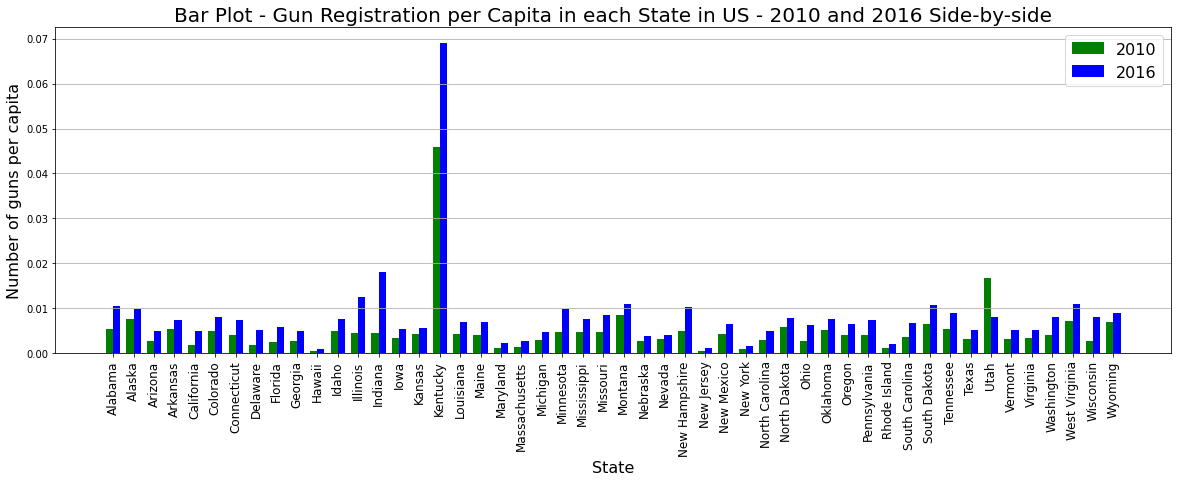

In [38]:
plt.figure(figsize=(20, 6))

ind = np.arange(len(df_cmb))    # the x locations for the states
wid = 0.35                      # the width of the bars

plt.bar(x=ind, height=df_cmb['gun-pc_10'], width=wid, color='g', label='2010')
plt.bar(x=ind+wid, height=df_cmb['gun-pc_16'], width=wid, color='b', label='2016')

plt.xlabel('State', 
           fontsize=16)
plt.ylabel('Number of guns per capita', 
           fontsize=16)
plt.title('Bar Plot - Gun Registration per Capita in each State in US - 2010 and 2016 Side-by-side', 
          fontsize=20)
plt.xticks(ind+wid/2, 
           labels=df_cmb.index, 
           rotation=90, 
           fontsize=12)

plt.grid(axis='y')
plt.legend(loc='best', fontsize=16);

So it seems quite clear that Kentucky registers the highest number of guns per capita in both years - they far out rank any other states. Not only that, its number had also seen a significant increase in 2016 from what was already a high number 6 years ago.

It is also interesting to see that the gun per capita figure has increased from 2010 to 2016 in all but one state - Utah. We shall pay more attention to how the census data look like in these two states - Kentucky and Utah to see what is/are correlated to this pattern in gun registration.

Next, let us assume that the populaiton size linearly changes with time. We have population in 2010 and 2016, so we can roughly estimate (via interpolation / extrapolation) the population in all other years and then divide the gun data in each of those years by the corresponding population size.

In [39]:
# we can use scipy extrapolation method to fill in the NaN's 
# unfortunately pandas does not yet have a credible method for 
# linear extrapolation outside the known range.
def extrap(row):
    # known data
    xi = [2010, 2016]
    yi = [row[2010], row[2016]]
    # positions to inter/extrapolate
    x = np.arange(1998, 2018)
    # spline order: 1 linear, 2 quadratic, 3 cubic ... 
    order = 1
    # do inter/extrapolation
    s = InterpolatedUnivariateSpline(xi, yi, k=order)
    row[x] = s(x)
    return row[x]

In [40]:
# create a separate population dataframe full of NaN's first.
df_pop = pd.DataFrame(np.nan, index=df_cmb.index, columns=np.arange(1998, 2018))

# then fill the columns 2010 and 2016 with population data from the census
df_pop[[2010, 2016]] = df_cmb[['pop_10', 'pop_16']]

# apply the extrapolation function
df_pop = df_pop.apply(extrap, axis=1)

df_pop.head()

,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
Alabama,4612608.0,4.626535e+06,4.640463e+06,4654390.0,4.668317e+06,4.682245e+06,4696172.0,4.710099e+06,4.724027e+06,4737954.0,4.751881e+06,4.765809e+06,4779736.0,4.793663e+06,4.807591e+06,4821518.0,4.835445e+06,4.849373e+06,4863300.0,4.877227e+06
Alaska,646905.0,6.521822e+05,6.574593e+05,662736.5,6.680137e+05,6.732908e+05,678568.0,6.838452e+05,6.891223e+05,694399.5,6.996767e+05,7.049538e+05,710231.0,7.155082e+05,7.207853e+05,726062.5,7.313397e+05,7.366168e+05,741894.0,7.471712e+05
Arizona,5313909.0,5.403751e+06,5.493594e+06,5583436.0,5.673278e+06,5.763121e+06,5852963.0,5.942805e+06,6.032648e+06,6122490.0,6.212332e+06,6.302175e+06,6392017.0,6.481859e+06,6.571702e+06,6661544.0,6.751386e+06,6.841229e+06,6931071.0,7.020913e+06
Arkansas,2771258.0,2.783313e+06,2.795368e+06,2807423.0,2.819478e+06,2.831533e+06,2843588.0,2.855643e+06,2.867698e+06,2879753.0,2.891808e+06,2.903863e+06,2915918.0,2.927973e+06,2.940028e+06,2952083.0,2.964138e+06,2.976193e+06,2988248.0,3.000303e+06
California,33261834.0,3.359451e+07,3.392719e+07,34259864.5,3.459254e+07,3.492522e+07,35257895.0,3.559057e+07,3.592325e+07,36255925.5,3.658860e+07,3.692128e+07,37253956.0,3.758663e+07,3.791931e+07,38251986.5,3.858466e+07,3.891734e+07,39250017.0,3.958269e+07


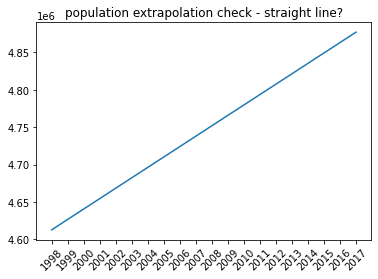

In [41]:
# Just to double check.....
plt.plot(df_pop.columns, df_pop.loc['Alabama'])
plt.title('population extrapolation check - straight line?')
plt.xticks(np.arange(1998, 2018, 1), rotation=45);

Yes we have now extrapolated the populaiton data for all the years. So we can then create a gun per capita table for the whole period between 1998 and 2017 by dividing the gun data in each year by population data estimated for that year. 

In [42]:
# create a gun per capita dataframe with all zeros
df_gun_pc = pd.DataFrame(0, index=df_pop.index, columns=df_pop.columns).add_prefix('pc_')

# do divisions for each year
for i, col in enumerate(df_gun_pc.columns):
    df_gun_pc[col] = df_gun_clean[df_gun_clean.columns[i]] / df_pop[df_pop.columns[i]]

Let's just take a moment to appreciate the state-wise statistics for per-capita guns from this dataframe.

In [43]:
pd.set_option('display.max_columns', None)    # set to display all columns
df_gun_pc.T.describe()

,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,Florida,Georgia,Hawaii,Idaho,Illinois,Indiana,Iowa,Kansas,Kentucky,Louisiana,Maine,Maryland,Massachusetts,Michigan,Minnesota,Mississippi,Missouri,Montana,Nebraska,Nevada,New Hampshire,New Jersey,New Mexico,New York,North Carolina,North Dakota,Ohio,Oklahoma,Oregon,Pennsylvania,Rhode Island,South Carolina,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.006111,0.006945,0.003041,0.005632,0.002220,0.005341,0.003787,0.002391,0.002684,0.003206,0.000624,0.005526,0.005218,0.005149,0.003314,0.004000,0.029608,0.004549,0.004081,0.001541,0.001676,0.003178,0.005118,0.005295,0.004726,0.008294,0.002735,0.002801,0.005148,0.000564,0.004377,0.001036,0.003573,0.006186,0.003181,0.005325,0.004297,0.004475,0.001189,0.003764,0.006453,0.005011,0.003414,0.006706,0.003355,0.003209,0.004081,0.007475,0.003913,0.006888
std,0.002740,0.002256,0.000971,0.001100,0.000991,0.001607,0.001978,0.001184,0.001424,0.001059,0.000244,0.001444,0.002904,0.004374,0.000837,0.001271,0.025352,0.001218,0.001405,0.000548,0.000791,0.000742,0.002482,0.000989,0.002113,0.001870,0.000640,0.000976,0.002611,0.000282,0.001221,0.000377,0.001701,0.001891,0.001386,0.001699,0.001193,0.001547,0.000530,0.001567,0.002237,0.002212,0.000974,0.006577,0.001000,0.001133,0.001888,0.002250,0.001932,0.001776
min,0.003945,0.003080,0.001642,0.003925,0.001014,0.002970,0.000962,0.001352,0.001065,0.000226,0.000176,0.002746,0.001609,0.001820,0.002524,0.002256,0.003845,0.003259,0.001553,0.000852,0.000120,0.001562,0.001243,0.004252,0.002083,0.003627,0.001999,0.001449,0.000954,0.000224,0.002241,0.000395,0.002342,0.002428,0.001427,0.002946,0.002121,0.001927,0.000507,0.001210,0.001933,0.002159,0.002090,0.002160,0.001685,0.001755,0.001072,0.003742,0.001403,0.003353
25%,0.004111,0.005055,0.002241,0.004882,0.001595,0.003796,0.002254,0.001630,0.001546,0.002669,0.000478,0.004540,0.003290,0.002429,0.002686,0.002918,0.004609,0.003427,0.003159,0.001209,0.001273,0.002842,0.003537,0.004628,0.002943,0.007175,0.002264,0.001841,0.003442,0.000362,0.003434,0.000724,0.002604,0.004920,0.002176,0.004007,0.003478,0.003402,0.000783,0.002672,0.005188,0.003263,0.002675,0.002633,0.002685,0.002309,0.002738,0.005919,0.002718,0.005442
50%,0.004848,0.006569,0.002743,0.005499,0.001959,0.005264,0.003172,0.001750,0.002146,0.003180,0.000523,0.005136,0.003912,0.002787,0.002911,0.003497,0.030407,0.004192,0.003444,0.001310,0.001651,0.003002,0.004197,0.004997,0.004173,0.008095,0.002525,0.002711,0.004215,0.000412,0.004103,0.000941,0.002983,0.005716,0.002456,0.004685,0.003997,0.003846,0.000917,0.003219,0.006086,0.003790,0.003071,0.004856,0.002938,0.002769,0.003804,0.006385,0.002810,0.006751
75%,0.007526,0.008768,0.003885,0.006163,0.002612,0.006691,0.004925,0.002999,0.003764,0.003996,0.000800,0.006721,0.007080,0.006446,0.003909,0.004990,0.046148,0.005394,0.005328,0.001801,0.002167,0.003580,0.006967,0.006060,0.006713,0.009466,0.002997,0.003524,0.007838,0.000817,0.005659,0.001452,0.004182,0.007499,0.004350,0.006704,0.005212,0.005991,0.001645,0.005091,0.008354,0.006777,0.004297,0.007544,0.004300,0.004319,0.005698,0.009481,0.005020,0.007986
max,0.012674,0.010720,0.005005,0.007897,0.005047,0.008130,0.007402,0.005202,0.005803,0.004954,0.001050,0.008579,0.012525,0.018050,0.005377,0.006600,0.085281,0.006975,0.006984,0.003268,0.003136,0.004865,0.010585,0.007700,0.008648,0.011305,0.004087,0.004387,0.010311,0.001135,0.006456,0.001708,0.00

It appears that Kentucky has both high mean and high standard deviation than the others - highlighting the outstanding gun statistics in this state.

Okay - let's see which other state(s) have also consistently reported a high per-capita number of gun registrations over the years.

In [44]:
df_gun_pc[df_gun_pc == df_gun_pc.max()].dropna(how='all')

,pc_1998,pc_1999,pc_2000,pc_2001,pc_2002,pc_2003,pc_2004,pc_2005,pc_2006,pc_2007,pc_2008,pc_2009,pc_2010,pc_2011,pc_2012,pc_2013,pc_2014,pc_2015,pc_2016,pc_2017
Kentucky,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.015433,0.03084,0.036398,0.042207,0.045813,0.043638,0.049356,0.029973,0.047153,0.060668,0.069057,0.085281
Mississippi,0.004462,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Montana,NaN,0.006822,0.006578,0.006847,0.006924,0.007259,0.007436,0.007411,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


It appears that based on our extrapolated population data, Montana also had a high per-capita gun numbers between 1999 and 2005 (7 consecutive years), and its position had since then been taken over by Kentucky all the way to the end of the recorded years (for 12 consecutive years). 
Let's make a line plot to compare the trend of gun data in Montana and Kentucky:

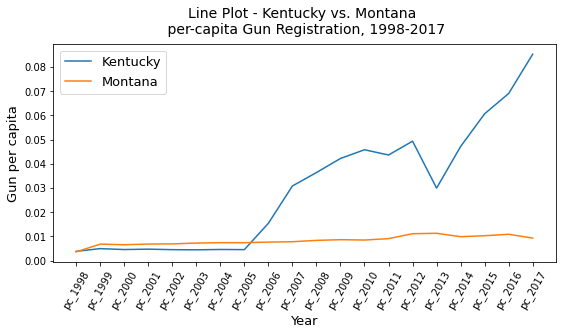

In [45]:
plt.figure(figsize=(9,4))
plt.plot(df_gun_pc.loc[['Kentucky', 'Montana']].T)

plt.xticks(rotation=60)
plt.xlabel('Year', fontsize=13)
plt.ylabel('Gun per capita', fontsize=13)
plt.title('Line Plot - Kentucky vs. Montana \n per-capita Gun Registration, 1998-2017',
          y=1.02, fontsize=14)

plt.legend(labels=['Kentucky', 'Montana'], fontsize=13);

It appears that Montana has maintained a steady level of per-capita gun numbers over the course of 20 years, while Kentucky started off steadiy but then went on rampage from 2005. I wonder if the lead by Montana in the first several years was actually credible - to do this, we need to compute a 95% confidence interval for the difference between state means for the first 7 years (1999-2005 inclusive).

In [46]:
cm = sms.CompareMeans(sms.DescrStatsW(df_gun_pc.loc['Kentucky', 'pc_1999':'pc_2005']), 
                      sms.DescrStatsW(df_gun_pc.loc['Montana', 'pc_1999':'pc_2005']))
lcd, ucd = cm.tconfint_diff(usevar='unequal')
lcd, ucd

(-0.0027149761358255457, -0.002080386382590758)

So, although Montana did take the lead (at 95% confidence level) in the first several years, the lead was not that obvious (only ~0.002 guns per capita), and they were swiftly overtaken by Kentucky in 2005/06 by a fairly large amount.

Since Kentucky is obviously off the scale compared against all the other states, let's make a heatmap for all the other states to see their per-capita gun number changes over time (particularly where the peaks are).

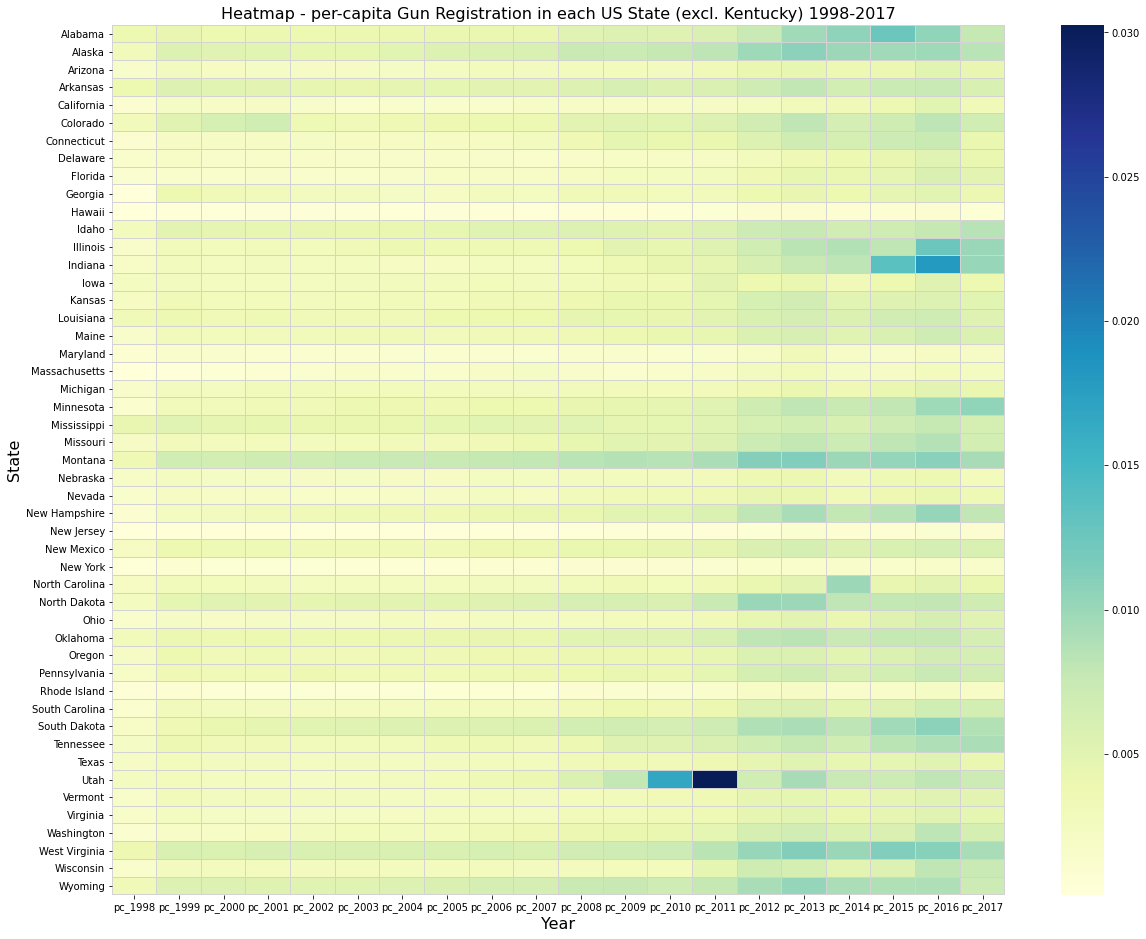

In [47]:
plt.figure(figsize=(20,16))

sns.heatmap(df_gun_pc.drop('Kentucky', axis=0), cmap="YlGnBu", linecolor='lightgrey', linewidths=0.007)

plt.xlabel('Year', fontsize=16)
plt.ylabel('State', fontsize=16)
plt.title('Heatmap - per-capita Gun Registration in each US State (excl. Kentucky) 1998-2017', fontsize=16);

From the heatmap, we can see that the drop in numbers in Utah (previously identified for 2010-2016) was in fact due to a spurious-like spike in 2010/11, and the dropped numbers are actually the norm (expected). The heatmap also indicates that "rust belt states" such as Indianna and Illinois (and perhaps also West Virginia) have recently recorded a surge in gun registration. Also as the colours generally get darker towards the later years, it is credible to claim that the overall trend of gun purchases is steering upwards.

We can examine the interesting discovery about Utah with a box plot below. 

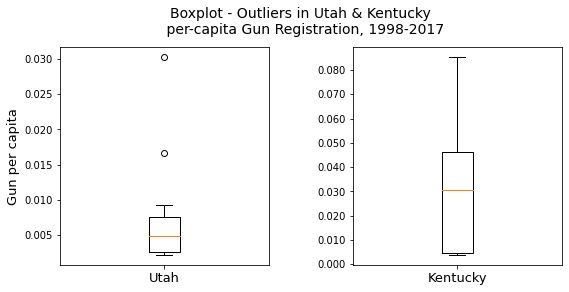

In [48]:
fig = plt.figure(figsize=(9,4))
fig.suptitle('Boxplot - Outliers in Utah & Kentucky \n per-capita Gun Registration, 1998-2017', 
             y=1.02, fontsize=14)
plt.subplots_adjust(wspace=.4)

# make a subplot for Utah
ax1 = fig.add_subplot(121)
ax1.boxplot(df_gun_pc.loc['Utah'])
ax1.set_xticklabels(['Utah'], fontsize=13)
ax1.set_ylabel('Gun per capita', fontsize=13)

# also add a subplot for Kentucky to show confidence in their extremes
# (subplot instead of showing on the same plot since the scales are off)
ax2 = fig.add_subplot(122)
ax2.boxplot(df_gun_pc.loc['Kentucky'])
ax2.set_xticklabels(['Kentucky'], fontsize=13)
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.3f'));

So the spikes in gun number from Utah were indeed outliers - we remain suspecious about their magnitude.

Finally, to wrap up this section on 'top gun' state, let's make a choropleth map to visualise per-capita gun intensity levels across all US states. We will use the 2016 data as this has been provided (than estimated with an assumption here).

In [49]:
# make a separate dataframe for 2016 from the gun_pc dataframe
# this will later be used to create a choropleth map
# note that Kentucky would override the coloring if not excluded
df_gun_pc_16 = df_gun_pc[['pc_2016']].drop('Kentucky').reset_index().rename(columns={'index': 'state'})

ssl._create_default_https_context = ssl._create_unverified_context   # urlopen certificate overwrite
with urlopen('https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json') \
    as response:
    states = json.load(response)              # citing US states data from Github 

m = folium.Map(location=[43, -100], zoom_start=4)    # locate US (incl. Alaska)
c = folium.Choropleth(
    geo_data=states,
    name="Choropleth for per-capita Gun Registration in 2016",
    data=df_gun_pc_16,
    columns=['state', 'pc_2016'],             # Kentucky will be displayed with an off-scale colour
    key_on="feature.properties.name",
    fill_color="YlGnBu",
    fill_opacity=0.7,
    line_opacity=.1,
    legend_name="Gun per capita 2016",
).add_to(m)

folium.LayerControl().add_to(m)

c.geojson.add_child(
    folium.features.GeoJsonTooltip(['name'],labels=False)    # interactive map - hover over to see state name
)

m

In conclusion, we are reasonably confident that Kentucky has the highest gun registration number per capita in general over the period of 1998-2017. Apart from Kentucky which has consistently seen high gun numbers, Indianna and Illinois may have also seen a surge in gun registrations in recent years (~2017). Interestingly, one thing in common amongst them is that they are all "rust belt states". In addition, as a general comment here, the overall trend of gun purchases is steering upwards as years go on.

### What census data are most associated with high gun per capita?

In this section, we will examine the correlation between the per-capita gun registration numbers and the selected census data. Note that, having a correlation does not imply one causes the other in any case. It only quantifies the strength of the relationship between the features of a dataset. 

Since correlations are sensitive to variations in the dataset (correlation is a measure of covariance between two datasets over their individual variances), we will only use per-capita gun data from 2010 and 2016. We will not use data from the other years as they were estimated based on quite a strong assumption.

In [50]:
# let's look at the combined dataframe again
df_cmb.head(1)

,pop_16,pop_10,%<5yr_16,%<5yr_10,%<18yr_16,%<18yr_10,%>65yr_16,%>65yr_10,%fem_16,%fem_10,%white_16,%black_16,%indinat_16,%asian_16,%island_16,%multi_16,%latino_16,vet_11-15,%>hs_11-15,%>bsc_11-15,income-pac_11-15,%poverty_15,empl_15,pay-pa_15,%empl-delta_14-15,gun_1998,gun_1999,gun_2000,gun_2001,gun_2002,gun_2003,gun_2004,gun_2005,gun_2006,gun_2007,gun_2008,gun_2009,gun_2010,gun_2011,gun_2012,gun_2013,gun_2014,gun_2015,gun_2016,gun_2017,gun-pc_10,gun-pc_16
Alabama,4863300,4779736,0.06,0.064,0.226,0.237,0.161,0.138,0.516,0.515,0.693,0.268,0.007,0.014,0.001,0.016,0.042,363170,0.843,0.235,24091,0.171,1634391,67370353,0.019,18284.0,20563.0,18492.583333,19182.25,18417.333333,18789.916667,19166.416667,19656.083333,20264.666667,20446.25,24952.666667,26489.0,25717.25,28008.5,35946.333333,46990.0,51775.416667,61459.083333,51412.25,37418.111111,0.00538,0.010571


Be careful here as we've found out from the section above that Kentucky may cause some troubles to the spread of data (treat it as an outlier state), and hence 'distorting' our correlation figures. So we need to drop the row of Kentucky entirely prior to any correlation analysis.

In [51]:
df_for_corr = df_cmb.drop('Kentucky')

We can make a correlation matrix for gun per capita ("gun-pc" columns) against each of the feature (potentially) columns (i.e. those excluding population and gun data).

In [52]:
attr_cols = df_for_corr.columns[np.r_[2:25, -2, -1]]     # attribute columns from census data

# make a correlation matrix (pearson's r)
df_corr = df_for_corr[attr_cols].corr()[['gun-pc_10', 'gun-pc_16']].T
df_corr.style.background_gradient(cmap='coolwarm', axis=1)   # darker - more negative, lighter - more positive

,%<5yr_16,%<5yr_10,%<18yr_16,%<18yr_10,%>65yr_16,%>65yr_10,%fem_16,%fem_10,%white_16,%black_16,%indinat_16,%asian_16,%island_16,%multi_16,%latino_16,vet_11-15,%>hs_11-15,%>bsc_11-15,income-pac_11-15,%poverty_15,empl_15,pay-pa_15,%empl-delta_14-15,gun-pc_10,gun-pc_16
gun-pc_10,0.154434,0.179621,0.147909,0.138748,-0.028288,-0.035544,0.045030,0.045956,0.172911,-0.199265,0.301898,-0.307678,-0.118313,-0.135438,-0.156225,-0.323116,0.072234,-0.019228,-0.328383,0.058786,-0.327495,-0.334780,0.140332,1.000000,0.575066
gun-pc_16,0.079077,0.085815,0.089840,0.087017,0.063078,0.058270,0.069908,0.070967,0.192061,-0.083085,0.174246,-0.357392,-0.256465,-0.230631,-0.212551,-0.161347,0.079854,-0.034327,-0.304927,0.130983,-0.191424,-0.220952,0.002916,0.575066,1.000000


The correlation matrix has suggested several interesting trends:
- Percentage Asian has the strongest negative correlation (~-0.35) with per-capita gun numbers;
- Similar strong negative correlations are seen with per annum per capita income, number of Veterans, employment and annual payroll;
- percentage White has the strongest positive correlation (~0.19) with per-capita gun numbers (both 2016 data);
- amongst the age groups, it apears that a higher percentage minors is most associated with higher per-capita gun numbers;
- amongst the ethnic groups, it appears that apart from White, a higher percentage American Indian and Alaska Native is also highly correlated with higher per-capita gun numbers (especially when cross correlating 2010 with 2016 data);
- the economy data in general indicate that a lower pay/employment (or a higher poverty rate) has a relatively strong correlation with higher per-capita gun numbers.

Let's just visualise the two strongest correlations (both racial), veterans and the economic correlation with per-capita gun numbers:
1. relationship between percentage Asian and per-capita gun numbers,
2. relationship between percentage White and per-capita gun numbers, 
3. relationship between Veterans and per-capita gun numbers, and
4. relationship between per annum per capita income and per-capita gun numbers.

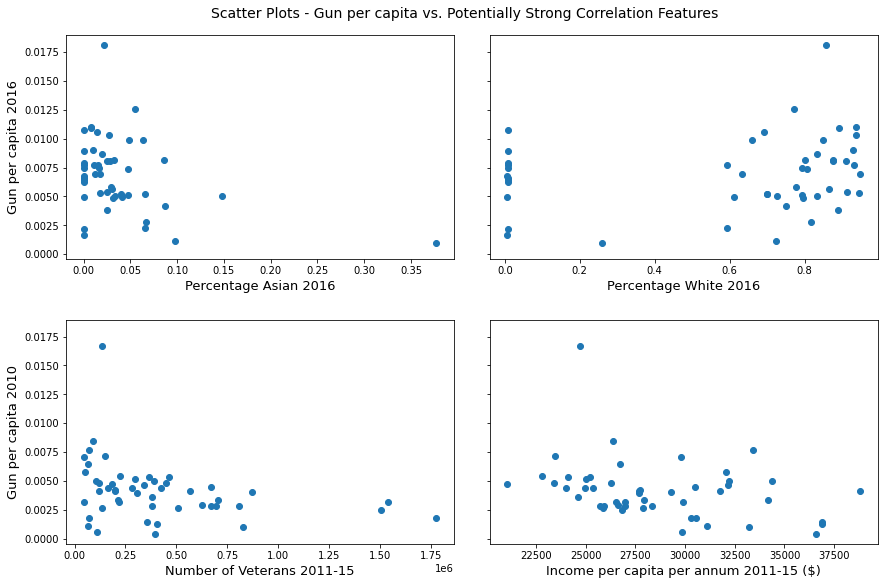

In [53]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharey=True, figsize=(12,8))
fig.suptitle('Scatter Plots - Gun per capita vs. Potentially Strong Correlation Features', fontsize=14)
plt.tight_layout(h_pad=4, w_pad=2)

# %asian_16 vs. gun-pc_16, scatterplot
ax1.scatter(df_for_corr['%asian_16'], df_for_corr['gun-pc_16'])
ax1.set_xlabel('Percentage Asian 2016', fontsize=13)
ax1.set_ylabel('Gun per capita 2016', fontsize=13)

# %white_16 vs. gun-pc_16, scatterplot
ax2.scatter(df_for_corr['%white_16'], df_for_corr['gun-pc_16'])
ax2.set_xlabel('Percentage White 2016', fontsize=13)

# vet_11-15 vs. gun-pc_10, scatterplot
ax3.scatter(df_for_corr['vet_11-15'], df_for_corr['gun-pc_10'])
ax3.set_xlabel('Number of Veterans 2011-15', fontsize=13)
ax3.set_ylabel('Gun per capita 2010', fontsize=13)

# income-pac_11-15 vs. gun-pc_10, scatterplot
ax4.scatter(df_for_corr['income-pac_11-15'], df_for_corr['gun-pc_10'])
ax4.set_xlabel('Income per capita per annum 2011-15 ($)', fontsize=13);

hmmm...although there does exist some pattern from the spread of data, the relatively high correlation values calculated before seem to be carried away by some outliers. So, there might not be a genuine relationship. Let's compute the p-value for these correlations to ascertain our belief.

In [54]:
# pearson's r correlation and p values
asian_corr = stats.pearsonr(df_for_corr['%asian_16'], df_for_corr['gun-pc_16'])
white_corr = stats.pearsonr(df_for_corr['%white_16'], df_for_corr['gun-pc_16'])
veter_corr = stats.pearsonr(df_for_corr['vet_11-15'], df_for_corr['gun-pc_10'])
incom_corr = stats.pearsonr(df_for_corr['income-pac_11-15'], df_for_corr['gun-pc_10'])

print('''\
correlation with percentage Asian:  {}
correlation with percentage White:  {}
correlation with veterans:          {}
correlation with per capita income: {}'''\
      .format(asian_corr, white_corr, veter_corr, incom_corr))

correlation with percentage Asian:  (-0.3573917626579351, 0.011701127449578774)
correlation with percentage White:  (0.19206054070565146, 0.18614690039999626)
correlation with veterans:          (-0.32311556096496924, 0.023540834785972718)
correlation with per capita income: (-0.3283827263621273, 0.02124350069741115)


Might as well investigate the other economic indicators (employment and payroll) for their correlation with gun data. We have found out from above that income has a relatively strong negative correlation with guns at a p-value of 0.02.

In [55]:
emply_corr = stats.pearsonr(df_for_corr['empl_15'], df_for_corr['gun-pc_10'])
payrl_corr = stats.pearsonr(df_for_corr['pay-pa_15'], df_for_corr['gun-pc_10'])
print('''\
correlation with employment: {}
correlation with payroll:    {}'''\
      .format(emply_corr, payrl_corr))

correlation with employment: (-0.32749548481216606, 0.021616687817591983)
correlation with payroll:    (-0.33478022711755584, 0.018710030264330997)


None of the p values are comfortably small but with a 95% confidence level setting, we are reasonably confident with the correlation as long as the corresponding p-value is below 0.05. Amongst the six features investigated above, percentage White population has a p-value larger than 0.05 and hence we do not believe in the strength of the correlation between this feature and the per-capita gun number.

But that said, we probably just don't have enough data to back us up - all features have only been reported once per state so the size of each feature is only just the number of states in US. A suggestion for improvement would be to sample more years of data so we can drop more points on the plots to help envisage a clearer pattern.

In conclusion, with the data at hand, we are reasonably confident that the a high gun per capita is most associated with a low percentage Asian (but not necessarily a high percentage of any other race), low number of veterans and low level of income (and also other economic indicators e.g. employment and payroll).

### What features are most associated with the high per-capita gun data in Kentucky?

In the last section, we had dropped out the row of Kentucky because we were concerned that the statistics for the state is so high that they could bias our impression about the census data - gun data relationship. 

This section will specifically examine the census and gun data from Kentucky, and make inferences about which feature(s) correlate the most to the outstanding gun data in the state. In other words, we know that the Kentucky gun data is most distinct from the other states, and we want to know which census data in Kentucky is/are also very distinct?

In [56]:
# Data from the state:
df_cmb.loc[['Kentucky']]

,pop_16,pop_10,%<5yr_16,%<5yr_10,%<18yr_16,%<18yr_10,%>65yr_16,%>65yr_10,%fem_16,%fem_10,%white_16,%black_16,%indinat_16,%asian_16,%island_16,%multi_16,%latino_16,vet_11-15,%>hs_11-15,%>bsc_11-15,income-pac_11-15,%poverty_15,empl_15,pay-pa_15,%empl-delta_14-15,gun_1998,gun_1999,gun_2000,gun_2001,gun_2002,gun_2003,gun_2004,gun_2005,gun_2006,gun_2007,gun_2008,gun_2009,gun_2010,gun_2011,gun_2012,gun_2013,gun_2014,gun_2015,gun_2016,gun_2017,gun-pc_10,gun-pc_16
Kentucky,4436974,4339367,0.062,0.065,0.228,0.236,0.156,0.133,0.507,0.508,0.88,0.083,0.003,0.015,0.001,0.019,0.035,297312,0.842,0.223,24063,0.185,1579477,63741066,0.029,15934.5,20684.333333,19158.0,19916.333333,19118.583333,18905.75,19581.166667,19382.416667,65966.583333,132320.833333,156758.416667,182464.833333,198798.25,190069.333333,215779.833333,131527.583333,207682.0,268197.583333,306403.916667,379775.111111,0.045813,0.069057


We need to find out which of the features from the census data is most different than that from all the other states. Because we would expect the differences to be in both directions - positive if Kentucky's is larger and negative if Kentucky's is smaller than the rest, we cannot just compare the differences on their own (i.e. positive is always greater than negative). 

We will need to apply a mean square to the 'Euclidean distances' between Kentucky and all the rest. By taking squares, we will not only align the sign of the differences but also highlight the features that are most distinct. Luckily we've already had a module in sklearn to perform a similar calculation: sklearn.metrics.mean_squared_error(). 

However, before we do any squaring operations, we need to make sure that all the data are on the same scale - otherwise columns such as income will naturally have ridiculously higher mean squared difference than the percentage columns! So, let's normalise (min-max) each columns first.

In [57]:
# create a new dataframe for all the features in census data
df_feat = df_cmb[df_cmb.columns[2:25]]

# min-max normalisation by column so all data are on the same scale [0,1]
df_feat_norm = (df_feat - df_feat.min()) / (df_feat.max() - df_feat.min())
df_feat_norm.loc[['Kentucky']]

,%<5yr_16,%<5yr_10,%<18yr_16,%<18yr_10,%>65yr_16,%>65yr_10,%fem_16,%fem_10,%white_16,%black_16,%indinat_16,%asian_16,%island_16,%multi_16,%latino_16,vet_11-15,%>hs_11-15,%>bsc_11-15,income-pac_11-15,%poverty_15,empl_15,pay-pa_15,%empl-delta_14-15
Kentucky,0.745393,0.682372,0.753358,0.747499,0.782334,0.767049,0.982392,0.984346,0.927748,0.219745,0.019543,0.039406,0.009707,0.07947,0.088675,0.145786,0.906479,0.547927,0.16939,0.888851,0.096388,0.063348,0.69697


Good - now all the values are scaled between 0 and 1. We can now perform the mean squre operation.

In [58]:
# leverage the mean square error funtion to compute 
# the mean squared differences between Kentucky and all the other states
ms_diff = df_feat_norm.apply(lambda col: mean_squared_error(col, [col['Kentucky']] * len(col)))
ms_diff.sort_values(ascending=False, inplace=True)

ms_diff

%poverty_15          0.256343
%fem_10              0.232589
%fem_16              0.231623
%white_16            0.228309
%>hs_11-15           0.199597
%>65yr_16            0.154537
%>65yr_10            0.149554
%<18yr_16            0.139566
%<5yr_16             0.138026
%<18yr_10            0.137223
%<5yr_10             0.117041
income-pac_11-15     0.114677
%>bsc_11-15          0.108308
%empl-delta_14-15    0.083662
%latino_16           0.080679
%black_16            0.067899
vet_11-15            0.051544
empl_15              0.040805
pay-pa_15            0.038249
%indinat_16          0.027050
%asian_16            0.026340
%island_16           0.020372
%multi_16            0.020371
dtype: float64

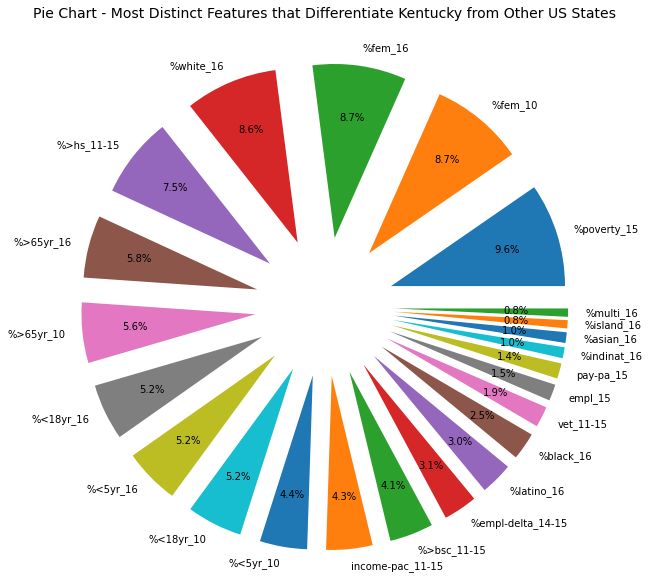

In [59]:
# visualise these with a pie chart
plt.figure(figsize=(8,8))

plt.pie(ms_diff, autopct="%.1f%%", explode=[0.4] * ms_diff.size, labels=ms_diff.index, pctdistance=0.7)

plt.title('Pie Chart - Most Distinct Features that Differentiate Kentucky from Other US States', 
          y=1.15, fontsize=14);

To conclude, percentage poverty, percentage female and percentage White population in Kentucky are most distinct (not necessarily the highest or lowest) from all the other states. These features from the census data are considered the most associated with the high per-capita gun numbers in Kentucky.

<a id='conclusions'></a>
## Conclusions

### Summary of Findings

1. By cleaning and analysing the census data and gun data for all the states in US, we have discovered that Kentucky has the highest gun registration number per capita in general over the period of 1998-2017. On the other hand, Indianna and Illinois had recorded a surge in gun registrations in more recent years towards 2017. Interestingly, these three states are all on the "rust belt". Furthermore, by showing the change in per-capita gun numbers over the course of 1998-2007 on a heatmap, we have concluded that the overall trend of gun purchases is steering upwards with time.
2. Constrained by the limited volume of data provided, at a 95% confidence level, we are reasonably comfortable to claim that the a high per-capita gun number is most correlated with a low percentage Asian (but not necessarily a high percentage of any other race), low number of veterans and low level of income (and also other economic indicators e.g. employment and payroll).
3. As of Kentucky which has consistently reported high per-capita gun numbers (and yet still increasing sharply) over the whole 20-year period, it turns out that it is most correlated with the state's percentage poverty, percentage female and percentage White population. Note that percentage poverty offers an alternative view on the state's economy, similar to the level of income, employment or payroll which had previously been identified as most associated with gun numbers in the other states.

All in all, the economic factor should not be overlooked when investigating the behaviour of gun purchases.

### Limitations

1. The top correlation features may be proved to be different ones if we had more data - at the moment there is only a maximum of two sets of census data provided for each state. 
2. A suggestion for improvement would be to sample more years of data.
3. The census data are incomplete and may be too generic, for example, there are missing age groups and missing some relevant variables to gun purchases.